# This notebook is the code, and explanation, for my Unit 2 Build Week Project

I've decided to build a classification model to predict whether an NFL play will be a run or pass, based on the field position, down, yards to first, and time remaining in the quarter, half, and game.

The initial dataset was downloaded from https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016. There were 255 columns, and over 500,000 rows. Most of the columns were the result of previous analysis that had been done. I removed those, and the rows that were anything other than a pass or run play, in Excel. The 600 MB file was too large to upload into Drive, which is where I put the smaller (still 60 MB) file that I conducted the analysis on, and model building for.

Now let's get to the actual work

## Dependencies

There are a number of imports that are necessary, they'll be in the first code cell.

In [1]:
# installing from the Lambda School git

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

# to mount Google Drive so that I can access the datafile
from google.colab import drive

# General purpose imports
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# To conduct the train, validate, test splits
from sklearn.model_selection import train_test_split

# For the RandomForestClassifier pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score

# For the XGBoost pipeline
from xgboost import XGBClassifier

# For the pdp plots
from pdpbox.pdp import pdp_isolate, pdp_plot

# For the shaply plot
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Imports completed, now I need to mount Google Drive so I can access the data.

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now to load the data into a pandas dataframe

In [3]:
path = '/content/drive/MyDrive/data/NFL Data Work Started.csv'
df = pd.read_csv(path)

I decided to create a unique index for the dataframe using two of the columns concatenated together. I didn't use date, because I'm not splitting the dataset by date.

In [4]:
# creating the unique index

df['index'] = df['game_id'].astype(str) + '_' + df['play_id'].astype(str)

# setting the index
df.set_index('index', inplace = True)

Now we have a dataset to work with. Exploratory Data Analysis was conducted previously. The following cell has comments to explain why certain remaining columns were dropped, and for specific rows.

In [5]:
# There are a number of NA results still in the dataframe.
# These correspond to two-point attempts, which happen outside the standard play calling procedures. Dropping them.
df.dropna(inplace = True)

# The next set of columns are not needed.
# In the case of 'game_id' and 'play_id', they are now the unique index.
# 'game_date' doesn't add value to the state of the game for each play.
# 'time' has been split out into seconds remaining for the quarter, half, and game.
# 'yrdln' is a duplicate of another column.
# The score columns are extra. The data is contained in another column.
# 'quarter_end' is just a binary identifier for if a play happened at the end of a quarter.
# 'desc' is where all of the data started from , but each one is unique and would provide no value by itself.

dcols = ['game_id', 'play_id', 'game_date', 'time', 'yrdln', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score',
         'desc', 'quarter_end']
df.drop(columns = dcols, inplace = True)

Now that the data is down to what's going to be used for the analysis, I'll bring up some stats on it.

In [6]:
# The head of the dataframe
df.head()

,home_team,away_team,qtr,down,ydstogo,posteam,posteam_type,defteam,distance_to_goal,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,drive,play_type,shotgun,no_huddle,home_timeouts_remaining,away_timeouts_remaining,score_differential
index,,,,,,,,,,,,,,,,,,,,
2009091000_68,PIT,TEN,1,1.0,10,PIT,home,TEN,58,893,1793.0,3593.0,Half1,1,pass,0,0,3,3,0
2009091000_92,PIT,TEN,1,2.0,5,PIT,home,TEN,53,856,1756.0,3556.0,Half1,1,run,0,0,3,3,0
2009091000_113,PIT,TEN,1,3.0,8,PIT,home,TEN,56,815,1715.0,3515.0,Half1,1,pass,1,0,3,3,0
2009091000_162,PIT,TEN,1,1.0,10,TEN,away,PIT,98,796,1696.0,3496.0,Half1,2,run,0,0,3,3,0
2009091000_183,PIT,TEN,1,2.0,10,TEN,away,PIT,98,760,1660.0,3460.0,Half1,2,pass,0,0,3,3,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318668 entries, 2009091000_68 to 2018121700_4106
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   home_team                  318668 non-null  object 
 1   away_team                  318668 non-null  object 
 2   qtr                        318668 non-null  int64  
 3   down                       318668 non-null  float64
 4   ydstogo                    318668 non-null  int64  
 5   posteam                    318668 non-null  object 
 6   posteam_type               318668 non-null  object 
 7   defteam                    318668 non-null  object 
 8   distance_to_goal           318668 non-null  int64  
 9   quarter_seconds_remaining  318668 non-null  int64  
 10  half_seconds_remaining     318668 non-null  float64
 11  game_seconds_remaining     318668 non-null  float64
 12  game_half                  318668 non-null  object 
 13  drive        

So, I'll need something to compare the model to, so I have an idea if the model is an improvement. Using the baseline accuracy, which is equal to the greatest percentage category. Essentially, if you always guess the most common play type, how often would you be correct?

In [8]:
baseline_accuracy = df['play_type'].value_counts(normalize = True)[0]
baseline_accuracy

0.5841910703302496

So, 58.4% of the time the most common play is called.

Now, let's start in on the first model setup.

In [9]:
# First, split the dataframe into train, validation, and test sets.

train, val = train_test_split(df, test_size = 0.2, random_state = 42)
train, test = train_test_split(train, test_size = len(val), random_state = 42)

Check out the shapes, just to make sure we're on the right track

In [10]:
train.shape, val.shape, test.shape

((191200, 20), (63734, 20), (63734, 20))

Ok, now setting the target, and creating the x matrix and y targets for each set.

In [11]:
# the target is 'play_type'
target = 'play_type'

# split out the different frames
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

Now the pipeline to run them through.

In [12]:
model_linear = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state = 42, n_jobs = -1)
)

With the pipeline prepared, time to fit everything.

In [13]:
model_linear.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['home_team', 'away_team', 'posteam',
                                      'posteam_type', 'defteam', 'game_half'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'home_team',
                                          'data_type': dtype('O'),
                                          'mapping': MIN     1
DEN     2
SD      3
DET     4
SF      5
JAC     6
TB      7
TEN     8
BAL     9
WAS    10
NYG    11
BUF    12
PHI    13
NE     14
NO     15
STL    16
GB     17
HOU    18
ATL    19
CAR...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_no

With the model fit, time to prepare some predictions for the validation set.

In [14]:
y_pred = model_linear.predict(X_val)

With predictions in hand, time to check the accuracy of the model and compare it to the baseline accuracy.

In [15]:
init_val_accuracy = accuracy_score(y_val, y_pred)
init_val_accuracy, baseline_accuracy

(0.7185175887281514, 0.5841910703302496)

Basically 72% compared to 58% for the baseline. An improvement of 14 percentage points.

Now, let's look at the feature importances.

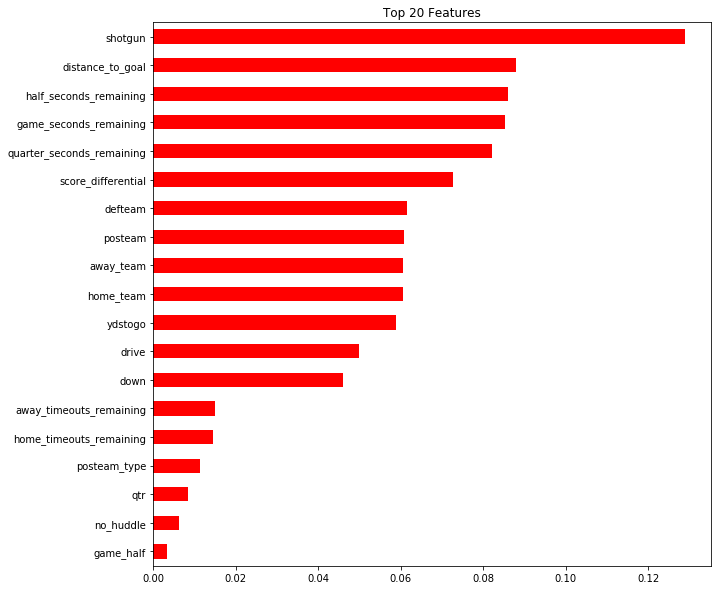

In [16]:
# Get them
rf = model_linear.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot them
n = 20
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} Features')
importances.sort_values()[-n:].plot.barh(color = 'red');

Interestingly enough, the shotgun formation is the strongest indicator. Not too surprising, though, considering the shotgun formation is generally seen as a passing formation. I am surprised that the no huddle isn't a bigger piece, given that going no huddle also tends to be a passing situation.

For the second model, I'm going to put it through a gradient boost, and hyperparameter tuning.

In [17]:
# create the pipeline
processor = make_pipeline(
    OrdinalEncoder()
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), (X_val_processed, y_val)]

model_boost = XGBClassifier(n_estimators = 100, n_jobs = -1)
model_boost.fit(X_train_processed, y_train, eval_set = eval_set, eval_metric = 'auc',
          early_stopping_rounds = 10)

[0]	validation_0-auc:0.756673	validation_1-auc:0.755033
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.759366	validation_1-auc:0.757413
[2]	validation_0-auc:0.761249	validation_1-auc:0.759713
[3]	validation_0-auc:0.765219	validation_1-auc:0.76439
[4]	validation_0-auc:0.766106	validation_1-auc:0.765299
[5]	validation_0-auc:0.769085	validation_1-auc:0.76888
[6]	validation_0-auc:0.770908	validation_1-auc:0.770667
[7]	validation_0-auc:0.771174	validation_1-auc:0.77084
[8]	validation_0-auc:0.771818	validation_1-auc:0.771654
[9]	validation_0-auc:0.773259	validation_1-auc:0.772928
[10]	validation_0-auc:0.773628	validation_1-auc:0.77323
[11]	validation_0-auc:0.776418	validation_1-auc:0.775936
[12]	validation_0-auc:0.776398	validation_1-auc:0.775896
[13]	validation_0-auc:0.77666	validation_1-auc:0.775996
[14]	validation_0-auc:0.77727	validation_1-auc:0.776466
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Time to get predictions and check accuracy.

In [18]:
# make predictions
y_pred_boost = model_boost.predict(X_val_processed)

# get the accuracy
boost_accuracy = accuracy_score(y_val, y_pred_boost)

# compare the boosted accuracy, the previous model accuracy, and the baseline
boost_accuracy, init_val_accuracy, baseline_accuracy

(0.7265352872877898, 0.7185175887281514, 0.5841910703302496)

Now let's do a partial dependence plot

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f85fdece610>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f86002c9710>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


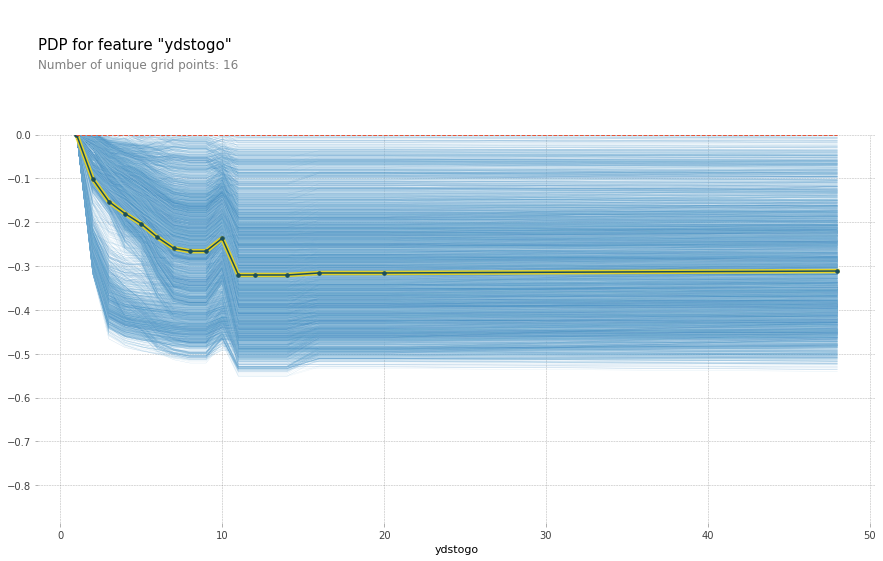

In [19]:
isolated = pdp_isolate(
    model = model_boost,
    dataset = X_val_processed,
    model_features = X_val.columns,
    feature = 'ydstogo',
    num_grid_points = 50
)

pdp_plot(isolated, feature_name = 'ydstogo', plot_lines = True, frac_to_plot=0.1)